In [1]:
# Import required packages
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta

In [2]:
##### IMPORT DATASET #####

url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'
data = pd.read_csv(url, skiprows=44, names=['Date','CO2 level'])

In [3]:
# First date of the dataset

data.head(5)

,Date,CO2 level
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [4]:
# Last date of the dataset 

data.tail(5)

,Date,CO2 level
3194,2020-10-31,411.92
3195,2020-11-07,412.37
3196,2020-11-14,412.67
3197,2020-11-21,412.98
3198,2020-11-28,414.32


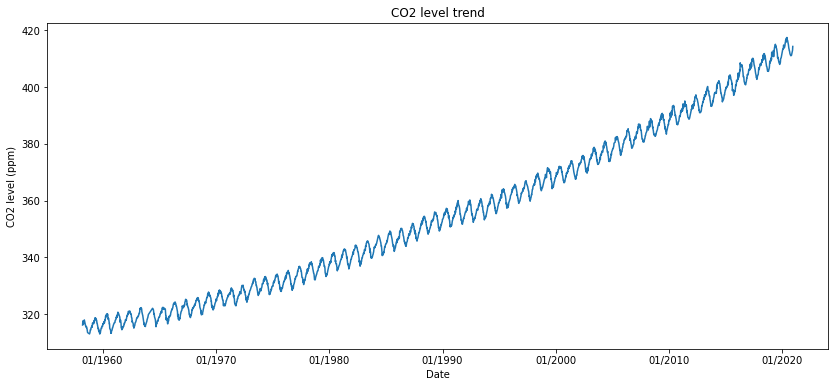

In [5]:
##### PLOT THE CO2 LEVEL TREND #####

# Tutorial: https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
# https://stackoverflow.com/questions/33743394/matplotlib-dateformatter-for-axis-label-not-working
 
# Create figure and plot space
fig, ax = plt.subplots(figsize=(14, 6))

# Add x-axis and y-axis
ax.plot(pd.to_datetime(data['Date']),
       data['CO2 level'])

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="CO2 level (ppm)",
       title="CO2 level trend")

# Define the date format
date_form = DateFormatter("%m/%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()


## PREPARE DATA FOR STAN MODELING

In [9]:
###### NORMALIZE CO2 LEVEL ######

def normalize(x):
    minX = min(x)
    maxX = max(x)
    return (x-minX)/(maxX - minX)

normalized_co2 = normalize(np.array(data['CO2 level']))
normalized_co2

array([0.03015797, 0.0408808 , 0.04451891, ..., 0.95385352, 0.95682145,
       0.96965055])

In [10]:
# Add the normalized CO2 as a new column to the dataset 

data['Normalized CO2'] = normalized_co2

In [11]:
# Change the type of string in column 'Date' to datetime type 

data['Date'] = pd.to_datetime(data['Date'])

In [12]:
# Check the type to see if it's datetime type 

type(data['Date'])

pandas.core.series.Series

In [13]:
# Assign the first date as day_0

day_0 = data['Date'][0]
day_0

Timestamp('1958-03-29 00:00:00')

In [14]:
# Add new column 'Days interval' to see the interval of days from the current
# observation to day_0

data['Days interval'] = data['Date'] - day_0
data['Days interval'] = data['Days interval'].dt.days
data

,Date,CO2 level,Normalized CO2,Days interval
0,1958-03-29,316.19,0.030158,0
1,1958-04-05,317.31,0.040881,7
2,1958-04-12,317.69,0.044519,14
3,1958-04-19,317.58,0.043466,21
4,1958-04-26,316.48,0.032934,28
...,...,...,...,...
3194,2020-10-31,411.92,0.946673,22862
3195,2020-11-07,412.37,0.950981,22869
3196,2020-11-14,412.67,0.953854,22876
3197,2020-11-21,412.98,0.956821,22883


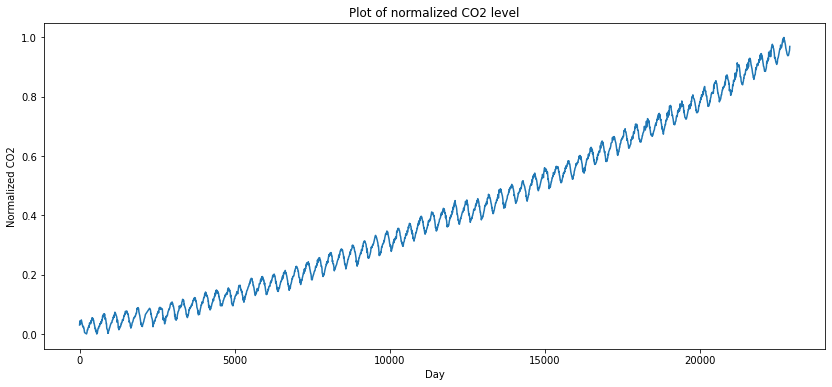

In [15]:
##### PLOT THE NORMALIZED CO2 LEVEL #####

# Prepare data for x and y-axis
number_of_days = data['Days interval']
normalized_co2 = data['Normalized CO2']

# Create figure and plot space
plt.figure(figsize=(14, 6))

# Add x-axis and y-axis
plt.plot(number_of_days, normalized_co2)

# Set title and labels for axes
plt.title("Plot of normalized CO2 level")
plt.xlabel("Day")
plt.ylabel("Normalized CO2")

plt.show()

In [16]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


## LINEAR MODEL

In [18]:
stan_code_linear = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=0> t;   // number of days in the dataset
    int<lower=0> days[t];   // t^th day after the first original date
    real<lower=0> co2_level[t];   // co2 level at each timestamp
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> c0;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c1;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c2;   // parameter to estimate seasonal variation of the linear likelihood function
    real<lower=0> c3;   // parameter to estimate seasonal variation of the linear likelihood function
    real<lower=0> c4;   // parameter to estimate noise of the linear likelihood function
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    c0 ~ cauchy(0, 1);   // prior over cauchy distribution
    c1 ~ cauchy(0, 1);   // prior over cauchy distribution
    c2 ~ cauchy(0, 1);   // prior over cauchy distribution
    c3 ~ cauchy(0, 1);   // prior over cauchy distribution
    c4 ~ normal(0, 10);   // prior over normal distribution

    for (T in 1:t){
        co2_level[T] ~ normal(c0 + c1*days[T] + c2*cos(2*3.14*days[T]/365.25 + c3), c4);   // likelihood function
    }
}

"""

In [19]:
# Compile Stan model
stan_model_linear = pystan.StanModel(model_code=stan_code_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70aef0c4545232299b941251e6b7f740 NOW.


In [20]:
# Prepare data for Stan model
stan_data_linear = {
    't': len(data),
    'days': data['Days interval'],
    'co2_level': data['Normalized CO2'],
}

In [21]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.
stan_results_linear = stan_model_linear.sampling(data=stan_data_linear)

In [22]:
# Print out the n_eff and Rhat of all parameters.
print(stan_results_linear)

Inference for Stan model: anon_model_70aef0c4545232299b941251e6b7f740.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   4.9e-5  7.3e-7 4.8e-5 1.1e-6 1.4e-5 3.4e-5 6.9e-5 1.8e-4   4326    1.0
c1   3.7e-5 9.4e-10 6.8e-8 3.7e-5 3.7e-5 3.7e-5 3.7e-5 3.7e-5   5288    1.0
c2     0.03  4.8e-4 1.4e-3   0.02   0.03   0.03   0.03   0.03      9   1.14
c3     1.49    1.82   2.57 2.3e-4 2.7e-3 7.6e-3   3.23   6.01      2 109.86
c4     0.05  1.1e-4 6.6e-4   0.05   0.05   0.05   0.05   0.05     34   1.04
lp__ 7865.0    8.71  12.41 7854.2 7857.6 7858.9 7870.6 7888.1      2   7.88

Samples were drawn using NUTS at Fri Dec 18 23:06:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [24]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

posterior_samples_linear = stan_results_linear.extract()
print(posterior_samples_linear)

OrderedDict([('c0', array([8.00606971e-05, 1.06292944e-04, 4.92926953e-05, ...,
       3.69051486e-06, 6.30054837e-05, 3.80744246e-05])), ('c1', array([3.71266623e-05, 3.71623163e-05, 3.72289596e-05, ...,
       3.70627389e-05, 3.71101039e-05, 3.73120681e-05])), ('c2', array([0.03043682, 0.02842261, 0.02805145, ..., 0.02582316, 0.02698728,
       0.02693311])), ('c3', array([5.89518100e+00, 5.92155033e+00, 5.90281362e+00, ...,
       1.11585627e-02, 4.15102774e-03, 8.72832128e-03])), ('c4', array([0.05109374, 0.05124342, 0.05106919, ..., 0.05148678, 0.05060279,
       0.05108601])), ('lp__', array([7885.10338844, 7887.62295496, 7886.67578318, ..., 7858.58474833,
       7859.19768012, 7855.65452598]))])


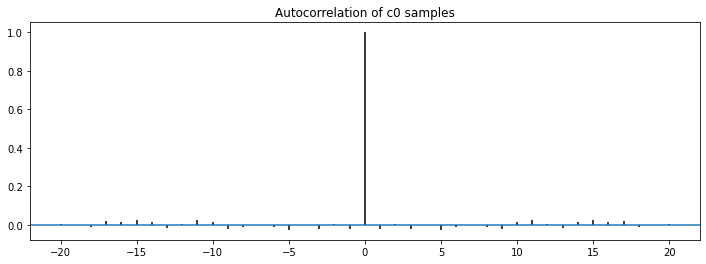

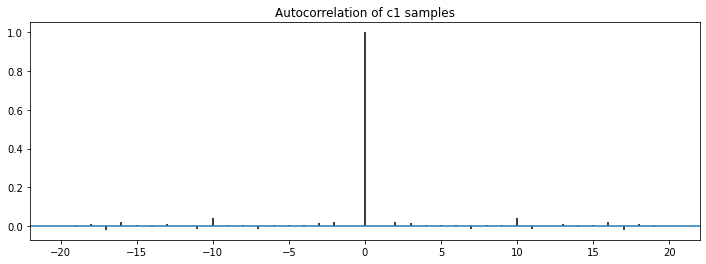

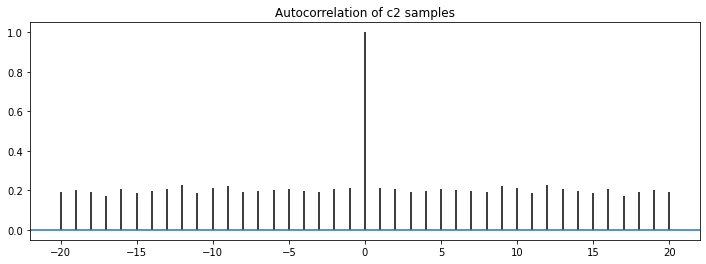

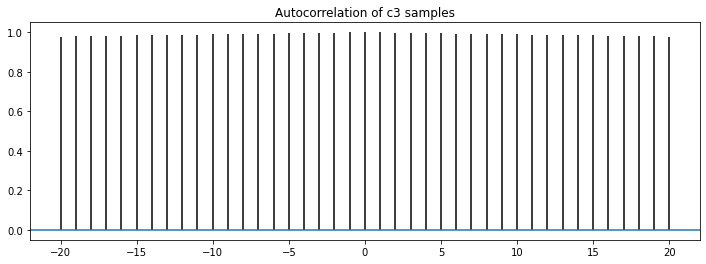

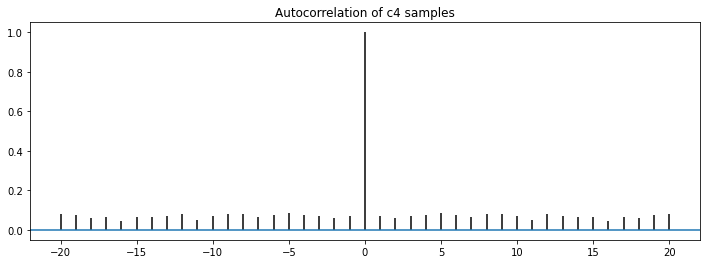

In [25]:
###### PLOT THE AUTOCORRELATION OF THE PARAMETERS ######
parameters = ['c0', 'c1', 'c2','c3','c4']

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_linear[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


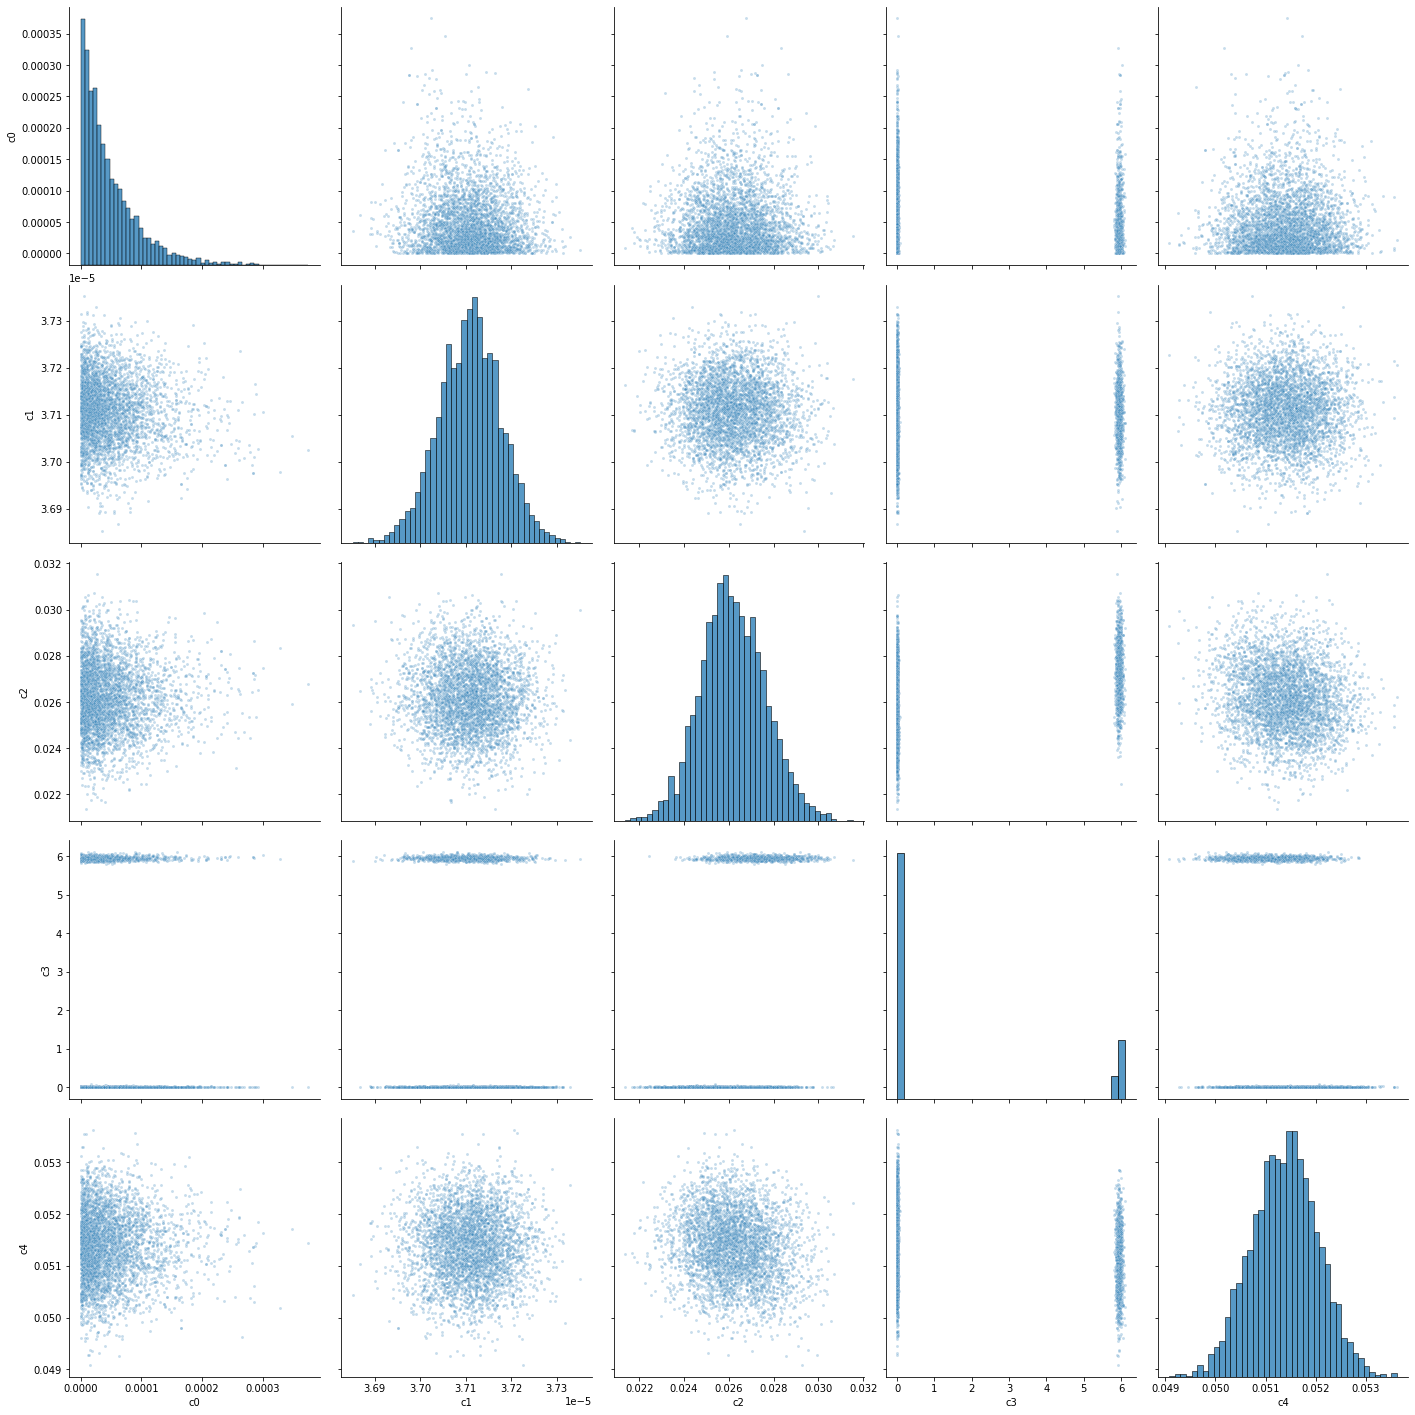

In [26]:
# Make pair plot of the posteriors over all parameters of the model.

df = pd.DataFrame(
    data=np.transpose([posterior_samples_linear[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## QUADRATIC MODEL

In [27]:
stan_code_quadratic = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=0> t;   // number of days in the dataset
    int<lower=0> days[t];   // t^th day after the first original date
    real<lower=0> co2_level[t];   // co2 level at each timestamp
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> c0;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c1;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c2;   // parameter to estimate seasonal variation of the linear likelihood function
    real<lower=0> c3;   // parameter to estimate seasonal variation of the linear likelihood function
    real<lower=0> c4;   // parameter to estimate noise of the linear likelihood function
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    c0 ~ cauchy(0, 0.2);   // prior over cauchy distribution
    c1 ~ cauchy(0, 1);   // prior over cauchy distribution
    c2 ~ cauchy(0, 1);   // prior over cauchy distribution
    c3 ~ cauchy(0, 1);   // prior over cauchy distribution
    c4 ~ normal(0, 10);   // prior over normal distribution

    for (T in 1:t){
        co2_level[T] ~ normal(c0 + c1*square(days[T]) + c2*cos(2*3.14*days[T]/365.25 + c3), c4);   // likelihood function
    }
}

"""

In [28]:
# Compile Stan model
stan_model_quadratic = pystan.StanModel(model_code=stan_code_quadratic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3b3db2ea8630b62bfe53da4fe3e04b92 NOW.


In [29]:
# Prepare Stan data
stan_data_quadratic = {
    't': len(data),
    'days': data['Days interval'],
    'co2_level': data['Normalized CO2'],
}

In [30]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.
stan_results_quadratic = stan_model_quadratic.sampling(data=stan_data_quadratic)

In [31]:
# Print out the n_eff and Rhat of all parameters.
print(stan_results_quadratic)

Inference for Stan model: anon_model_3b3db2ea8630b62bfe53da4fe3e04b92.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0      0.1  1.6e-5  8.9e-4    0.1    0.1    0.1    0.1    0.1   2973    1.0
c1   1.8e-9 6.3e-14 3.8e-12 1.7e-9 1.7e-9 1.8e-9 1.8e-9 1.8e-9   3673    1.0
c2     0.03  1.5e-5  8.8e-4   0.02   0.03   0.03   0.03   0.03   3478    1.0
c3   3.4e-3  5.5e-5  3.4e-3 7.7e-5 1.0e-3 2.4e-3 4.7e-3   0.01   3733    1.0
c4     0.03  7.1e-6  4.3e-4   0.03   0.03   0.03   0.03   0.04   3737    1.0
lp__ 9160.6    0.04    1.64 9156.5 9159.7 9160.9 9161.8 9162.7   1478    1.0

Samples were drawn using NUTS at Fri Dec 18 23:08:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [33]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

posterior_samples_quadratic = stan_results_quadratic.extract()
print(posterior_samples_quadratic)

OrderedDict([('c0', array([0.10274843, 0.10365988, 0.1037246 , ..., 0.10376996, 0.10101504,
       0.10469913])), ('c1', array([1.75583348e-09, 1.74868830e-09, 1.74730799e-09, ...,
       1.75397274e-09, 1.75740708e-09, 1.74418902e-09])), ('c2', array([0.02572691, 0.02643664, 0.02674305, ..., 0.02468157, 0.02633592,
       0.02620909])), ('c3', array([0.00273596, 0.00057215, 0.00158949, ..., 0.01253475, 0.00228875,
       0.00812087])), ('c4', array([0.03355282, 0.03395714, 0.03421196, ..., 0.03437712, 0.03402782,
       0.03454216])), ('lp__', array([9160.8173354 , 9161.69228703, 9162.13223136, ..., 9158.13047749,
       9160.84482917, 9160.33041034]))])


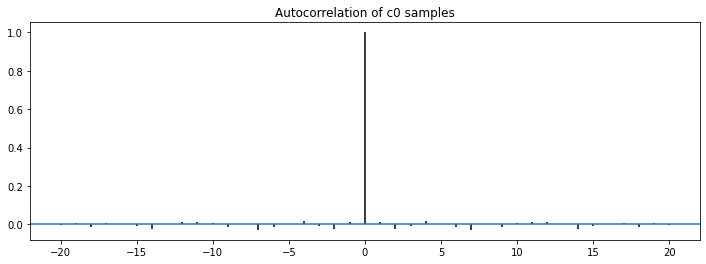

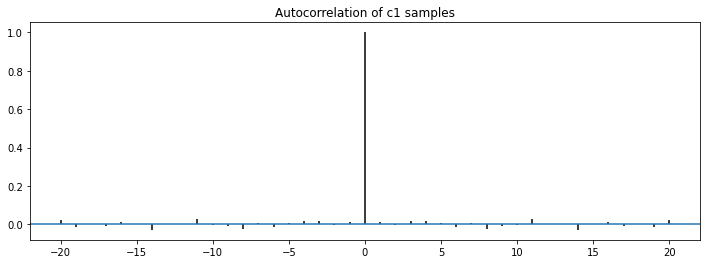

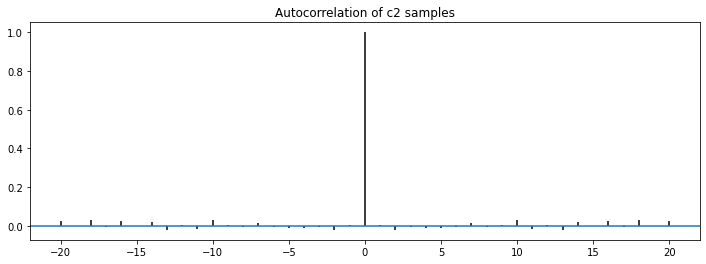

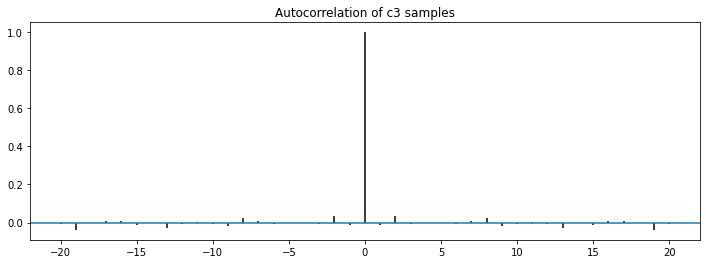

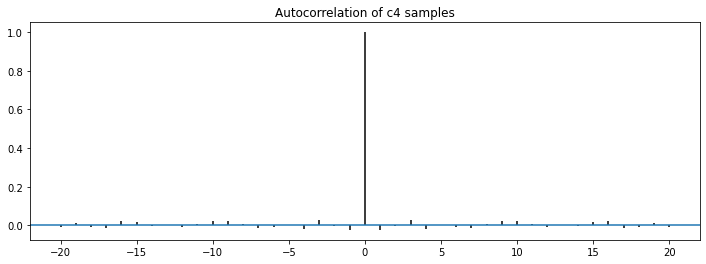

In [34]:
###### PLOT THE AUTOCORRELATION OF THE PARAMETERS ######
parameters = ['c0', 'c1', 'c2','c3','c4']

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_quadratic[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


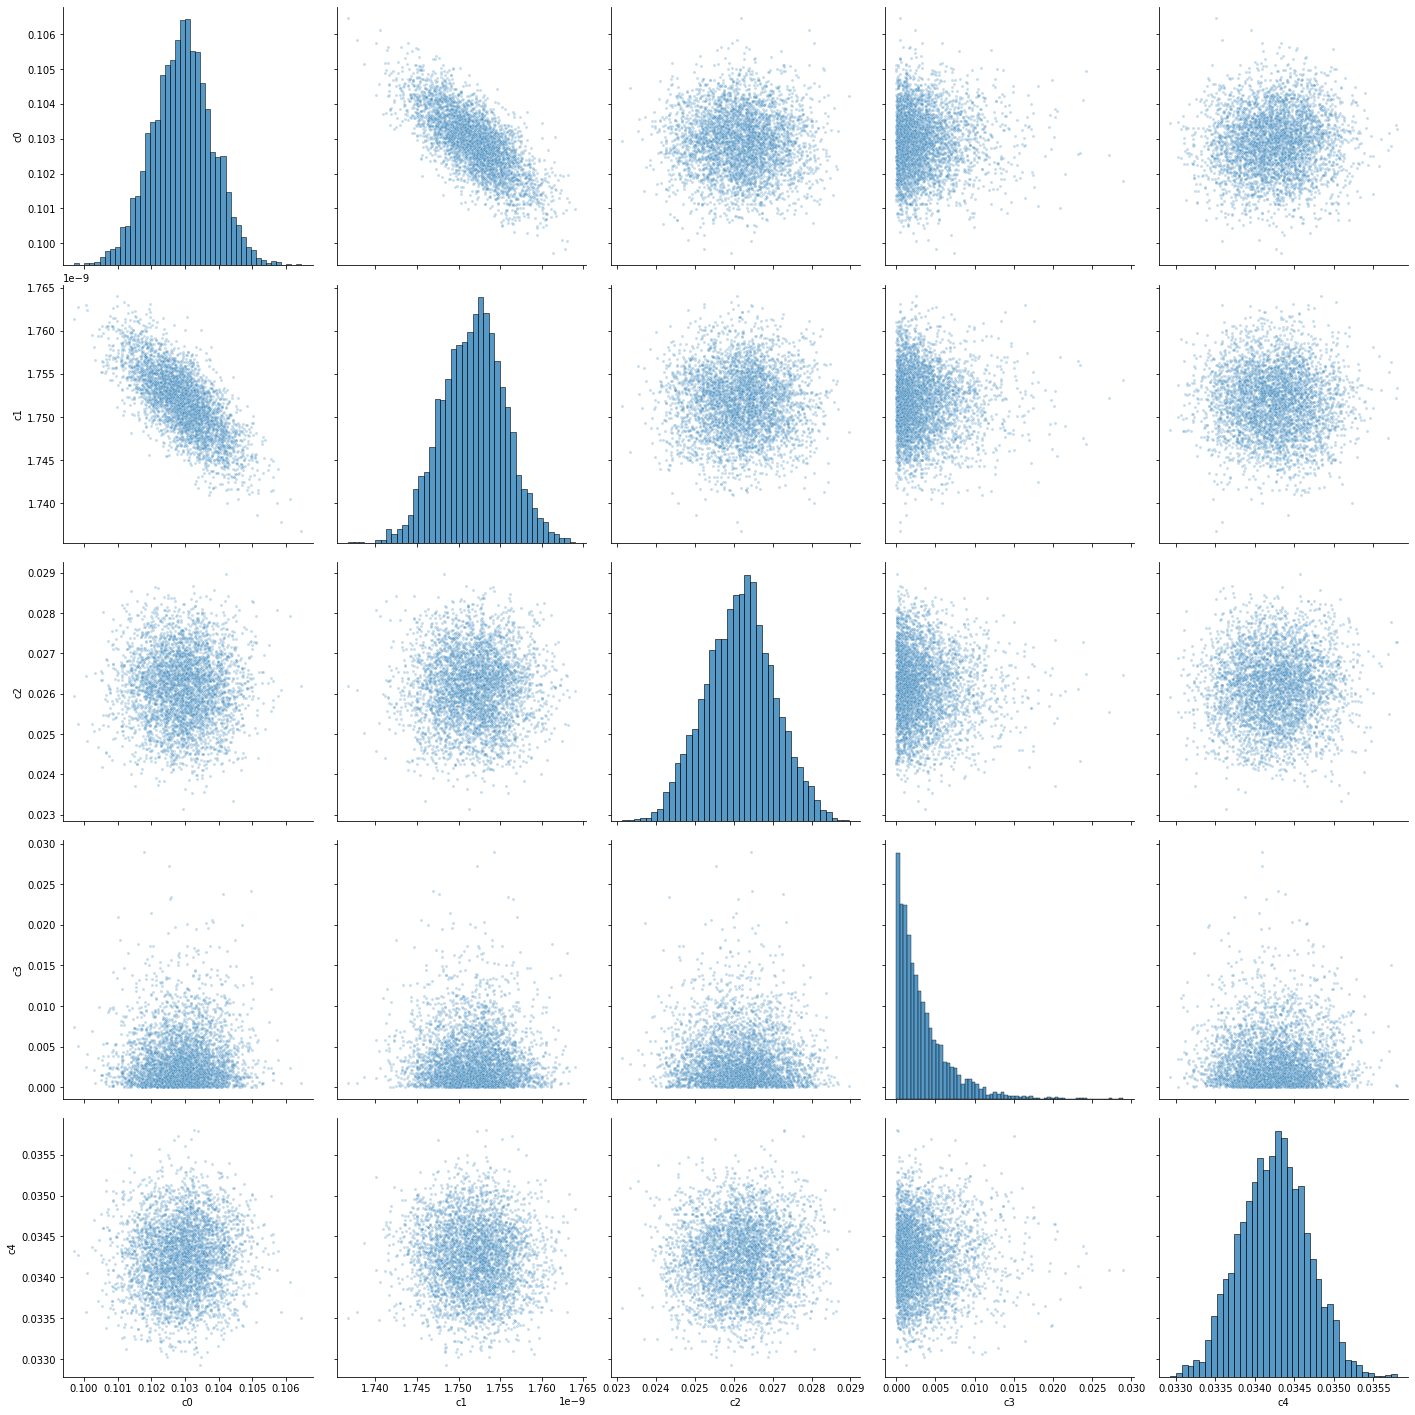

In [35]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([posterior_samples_quadratic[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## LINEAR-QUADRATIC MODEL

In [36]:
stan_code_linear_quad = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=0> t;   // number of days in the dataset
    int<lower=0> days[t];   // t^th day after the first original date
    real<lower=0> co2_level[t];   // co2 level at each timestamp
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> c0;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c1;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c10;   // parameter to estimate long-term trend of the linear likelihood function
    real<lower=0> c2;   // parameter to estimate seasonal variation of the linear likelihood function
    real<lower=0> c3;   // parameter to estimate seasonal variation of the linear likelihood function
    real<lower=0> c4;   // parameter to estimate noise of the linear likelihood function
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    c0 ~ cauchy(0, 1);   // prior over cauchy distribution
    c1 ~ cauchy(0, 1);   // prior over cauchy distribution
    c10 ~ cauchy(0, 0.2);   // prior over cauchy distribution
    c2 ~ cauchy(0, 1);   // prior over cauchy distribution
    c3 ~ cauchy(0, 1);   // prior over cauchy distribution
    c4 ~ normal(0, 10);  // prior over normal distribution

    for (T in 1:t){
        co2_level[T] ~ normal(c0 + c1*days[T] + c10*square(days[T]) + c2*cos(2*3.14*days[T]/365.25 + c3), c4);   // likelihood function
    }
}

"""

In [37]:
# Compile Stan model
stan_model_linear_quad = pystan.StanModel(model_code=stan_code_linear_quad)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d7d4c44b9d2f21f6f04a53a8d15bf177 NOW.


In [38]:
# Prepare Stan data
stan_data_linear_quad = {
    't': len(data),
    'days': data['Days interval'],
    'co2_level': data['Normalized CO2'],
}

In [39]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.
stan_results_linear_quad = stan_model_linear_quad.sampling(data=stan_data_linear_quad)

In [40]:
# Print out the n_eff and Rhat of all parameters.
print(stan_results_linear_quad)

Inference for Stan model: anon_model_d7d4c44b9d2f21f6f04a53a8d15bf177.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
c0      0.02  1.7e-5  6.1e-4    0.01    0.01    0.02    0.02    0.02   1261    1.0
c1    2.0e-5  3.8e-9  1.2e-7  2.0e-5  2.0e-5  2.0e-5  2.0e-5  2.0e-5   1012   1.01
c10  9.4e-10 1.6e-13 5.0e-12 9.3e-10 9.4e-10 9.4e-10 9.5e-10 9.5e-10   1011   1.01
c2      0.03  4.0e-4  6.1e-4    0.03    0.03    0.03    0.03    0.03      2   2.35
c3      1.49    1.83    2.59  1.5e-5  1.6e-4  4.1e-4    3.27    5.98      2 636.27
c4      0.01  5.1e-4  7.3e-4  9.5e-3    0.01    0.01    0.01    0.01      2   5.83
lp__   1.3e4  156.46  221.33   1.3e4   1.3e4   1.3e4   1.3e4   1.3e4      2 135.06

Samples were drawn using NUTS at Fri Dec 18 23:13:02 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the 

In [42]:
# Finally, we can extract the samples generated by Stan so that we
# can plot them or calculate any other functions or expected values
# we might be interested in.

posterior_samples_linear_quad = stan_results_linear_quad.extract()
print(posterior_samples_linear_quad)

OrderedDict([('c0', array([0.01595699, 0.01492427, 0.01557585, ..., 0.0160846 , 0.01620031,
       0.01508286])), ('c1', array([1.98647429e-05, 2.01329352e-05, 1.98592098e-05, ...,
       1.99646867e-05, 1.97257951e-05, 2.00489138e-05])), ('c10', array([9.42509079e-10, 9.30774956e-10, 9.46277014e-10, ...,
       9.38705856e-10, 9.50352706e-10, 9.36312667e-10])), ('c2', array([0.0274481 , 0.02725534, 0.02693335, ..., 0.02641707, 0.02616905,
       0.0265317 ])), ('c3', array([5.97439880e+00, 5.96006076e+00, 5.97500070e+00, ...,
       8.83856616e-04, 6.81985054e-04, 8.05623034e-05])), ('c4', array([0.00959001, 0.00953195, 0.0096599 , ..., 0.01136587, 0.0115519 ,
       0.01140463])), ('lp__', array([13188.65752948, 13184.03372641, 13188.4034647 , ...,
       12673.53816382, 12677.59034683, 12676.39534866]))])


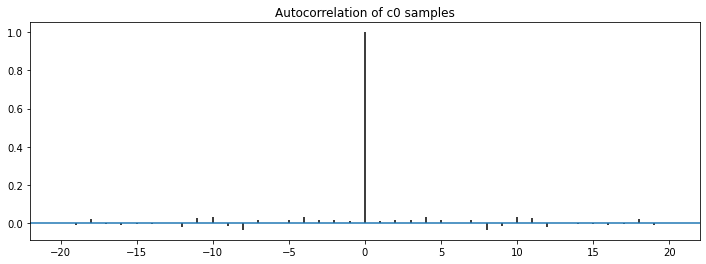

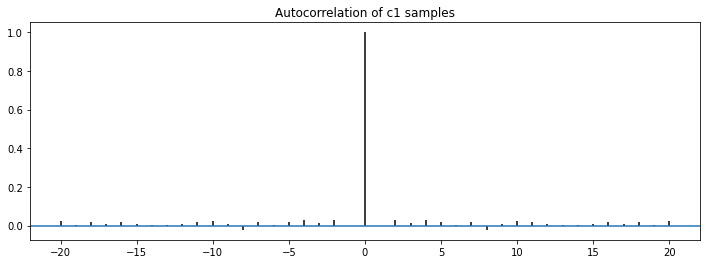

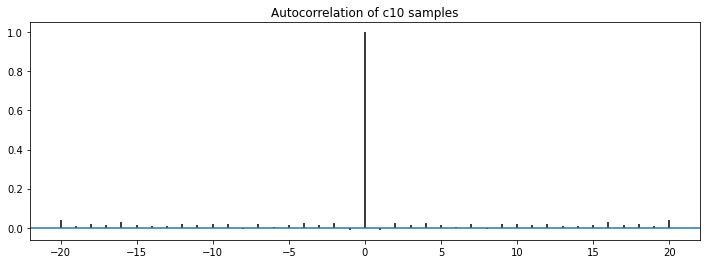

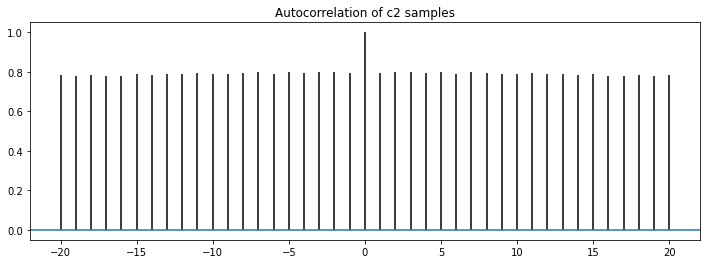

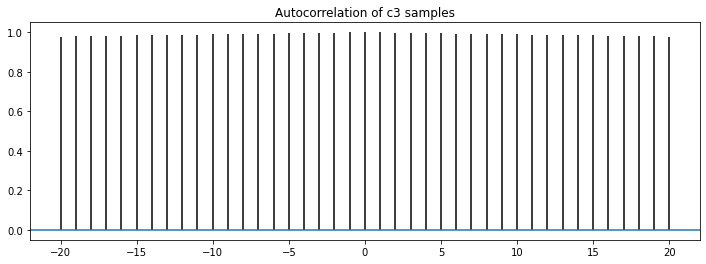

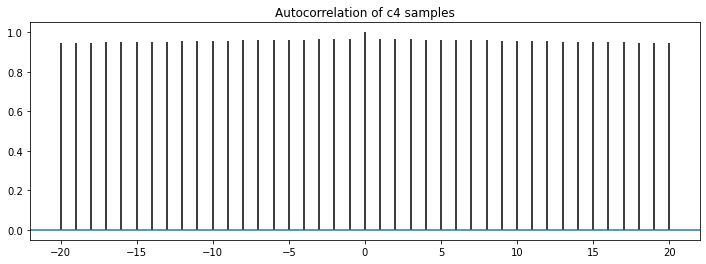

In [43]:
###### PLOT THE AUTOCORRELATION OF THE PARAMETERS ######

parameters = ['c0', 'c1', 'c10','c2','c3','c4']

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(posterior_samples_linear_quad[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


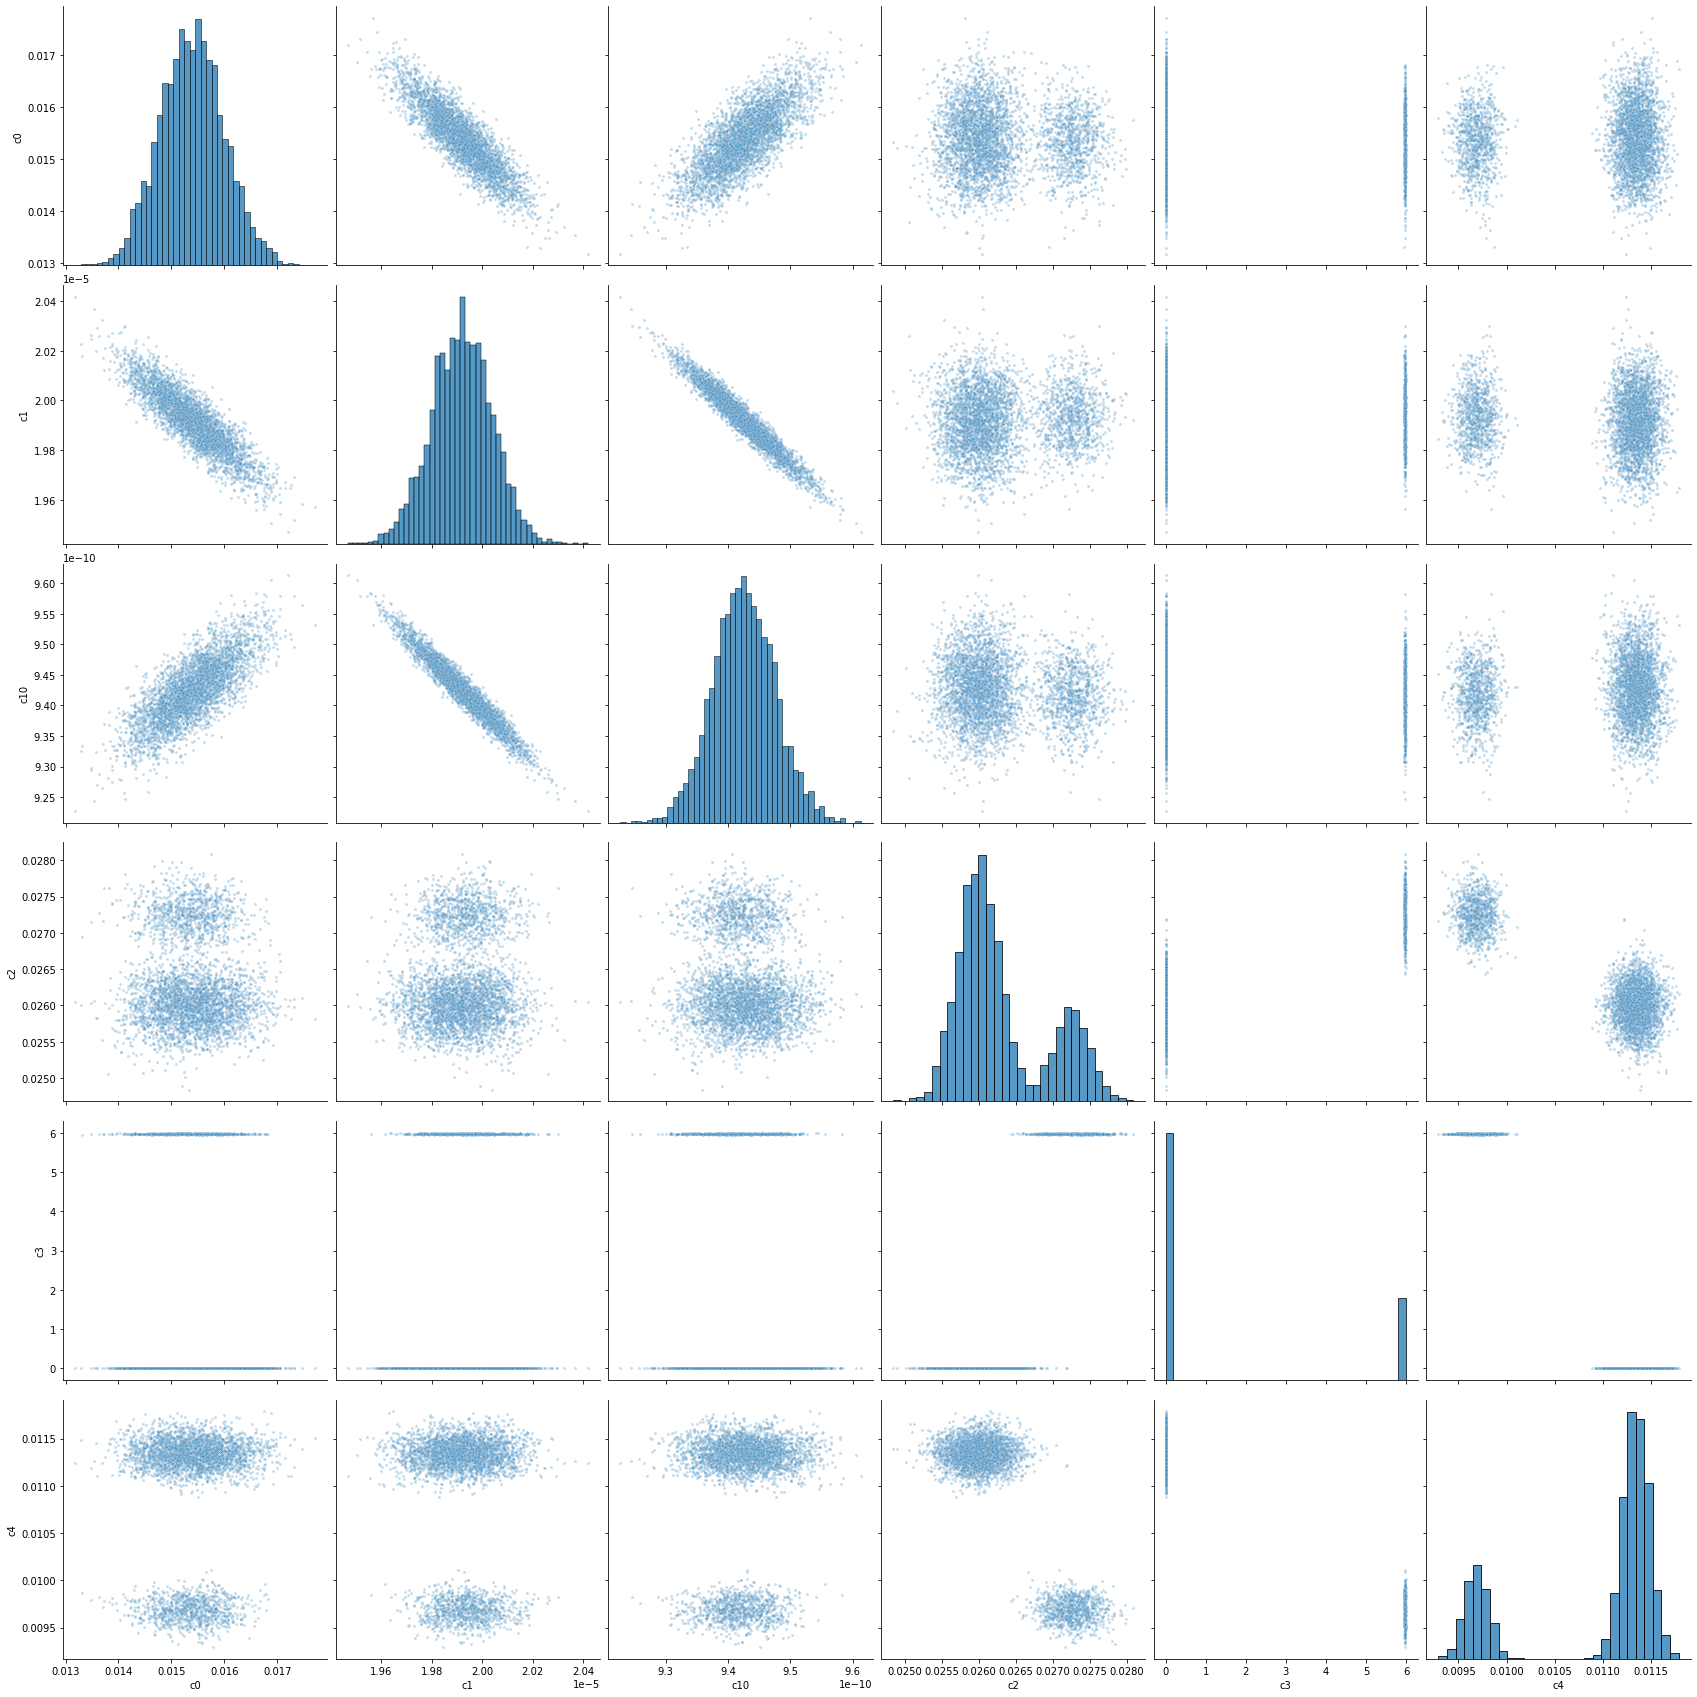

In [44]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([posterior_samples_linear_quad[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=4, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

## MODEL FITNESS: ROOT MEAN SQUARE ERROR


In [45]:
number_of_samples = len(posterior_samples_linear['c0'])
number_of_samples

4000

In [46]:
number_of_days = data['Days interval']
co2_level = data['CO2 level']

In [47]:
def denormalize_data(normalized_co2):
    maxCo2 = max(co2_level)
    minCo2 = min(co2_level)
    return normalized_co2*(maxCo2-minCo2) + minCo2

In [48]:
##### ROOT MEAN SQUARE ERROR (RMSE) #####
# Calculating roor-mean square error from all samples
predicted_data_linear = []
predicted_data_quadratic = []
predicted_data_linear_quad = []

rmse_linear = []
rmse_quadratic = []
rmse_linear_quad = []

for i in range(number_of_samples):
    # Calculate predicted data from the linear equation
    # Stan equation: co2_level[T] ~ normal(c0 + c1*days[T] + c2*cos(2*3.14*days[T]/365.25 + c3), c4)
    predicted_data_linear.append(denormalize_data(sts.norm.rvs(posterior_samples_linear['c0'][i] + posterior_samples_linear['c1'][i]*number_of_days + \
                            posterior_samples_linear['c2'][i]*np.cos(2*3.14*number_of_days/365.25 + posterior_samples_linear['c3'][i]), \
                            posterior_samples_linear['c4'][i])))

    # Calculate predicted data from the quadratic equation
    # Stan equation: co2_level[T] ~ normal(c0 + c1*square(days[T]) + c2*cos(2*3.14*days[T]/365.25 + c3), c4)
    predicted_data_quadratic.append(denormalize_data(sts.norm.rvs(posterior_samples_quadratic['c0'][i] + posterior_samples_quadratic['c1'][i]*(number_of_days**2) + \
                            posterior_samples_quadratic['c2'][i]*np.cos(2*3.14*number_of_days/365.25 + posterior_samples_quadratic['c3'][i]), \
                            posterior_samples_quadratic['c4'][i])))

    # Calculate predicted data from the linear-quadratic equation
    # Stan equation: co2_level[T] ~ normal(c0 + c1*days[T] + c10*square(days[T]) + c2*cos(2*3.14*days[T]/365.25 + c3), c4)
    predicted_data_linear_quad.append(denormalize_data(sts.norm.rvs(posterior_samples_linear_quad['c0'][i] + posterior_samples_linear_quad['c1'][i]*number_of_days + \
                                              posterior_samples_linear_quad['c10'][i]*(number_of_days**2) + \
                                              posterior_samples_linear_quad['c2'][i]*np.cos(2*3.14*number_of_days/365.25 + posterior_samples_linear_quad['c3'][i]), \
                                              posterior_samples_linear_quad['c4'][i])))
    
    # Calculate the RMSE = (real CO2 - predicted CO2).mean()
    rmse_linear.append(np.square(co2_level - predicted_data_linear[i]).mean())
    rmse_quadratic.append(np.square(co2_level - predicted_data_quadratic[i]).mean())
    rmse_linear_quad.append(np.square(co2_level - predicted_data_linear_quad[i]).mean())

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0, 0.5, 'Count')

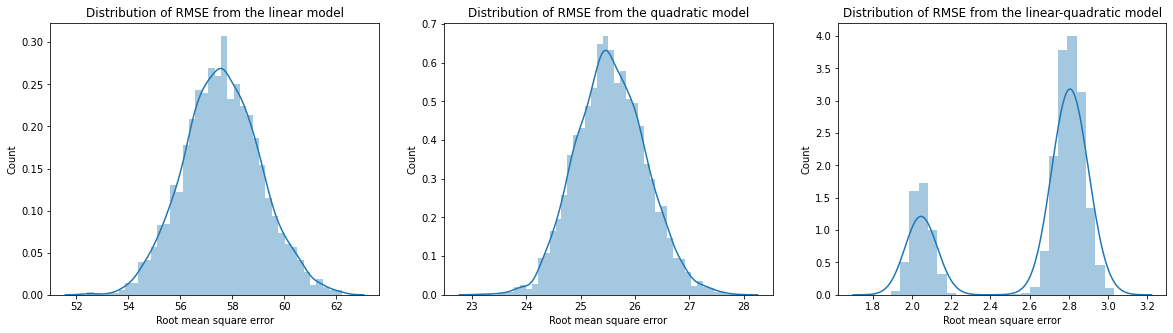

In [49]:
##### Plot distribution for RMSE #####

fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(rmse_linear)
plt.title("Distribution of RMSE from the linear model")
plt.xlabel("Root mean square error")
plt.ylabel("Count")

plt.subplot(1,3,2)
sns.distplot(rmse_quadratic)
plt.title("Distribution of RMSE from the quadratic model")
plt.xlabel("Root mean square error")
plt.ylabel("Count")

plt.subplot(1,3,3)
sns.distplot(rmse_linear_quad)
plt.title("Distribution of RMSE from the linear-quadratic model")
plt.xlabel("Root mean square error")
plt.ylabel("Count")

## TEST STATISTIC: MEAN AND STANDARD DEVIATION


In [50]:
def test_statistics(model_name, test_name, predict_data, func):
    p_val = sum([1 for i in func(predict_data, 1) if func(co2_level) > i]) / 4000
    plt.hist(func(predict_data, 1), alpha=0.25)
    plt.axvline(x=func(co2_level), color='red', label='Real value')
    plt.title(f'{model_name} model: {test_name} distribution in predicted data')
    plt.xlabel(f'{test_name}')
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    print(f'p-value is: {p_val}')

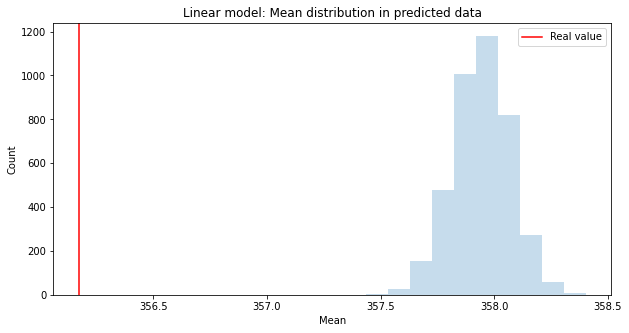

p-value is: 0.0


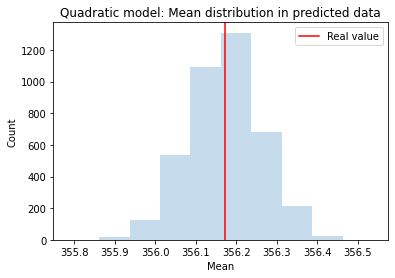

p-value is: 0.4915


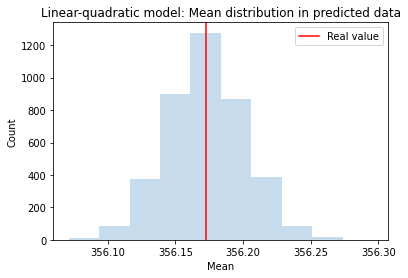

p-value is: 0.4985


In [51]:
fig = plt.figure(figsize=(10,5))
test_statistics("Linear","Mean", predicted_data_linear, np.mean)
test_statistics("Quadratic","Mean", predicted_data_quadratic, np.mean)
test_statistics("Linear-quadratic","Mean", predicted_data_linear_quad, np.mean)

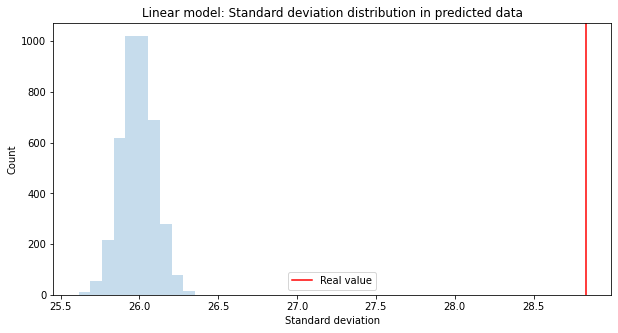

p-value is: 1.0


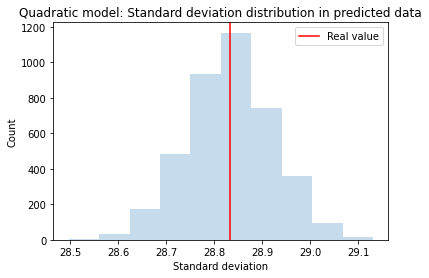

p-value is: 0.4955


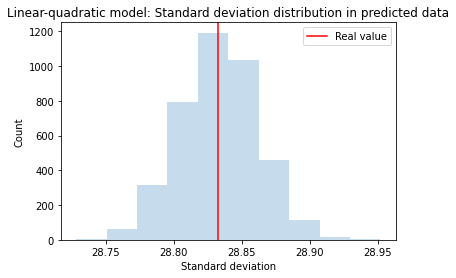

p-value is: 0.49175


In [52]:
fig = plt.figure(figsize=(10,5))
test_statistics("Linear","Standard deviation", predicted_data_linear, np.std)
test_statistics("Quadratic","Standard deviation", predicted_data_quadratic, np.std)
test_statistics("Linear-quadratic","Standard deviation", predicted_data_linear_quad, np.std)

## ESTIMATION FOR ATMOSPHERIC CO2 LEVELS PROJECTED UNTIL THE START OF 2060


In [54]:
def linear_model(samples, number_of_days, func, args=0):
    # Stan equation: co2_level[T] ~ normal(c0 + c1*days[T] + c2*cos(2*3.14*days[T]/365.25 + c3), c4)
    return denormalize_data(sts.norm.rvs(func(samples['c0'], args) + func(samples['c1'], args)*number_of_days + \
                          func(samples['c2'],args)*np.cos(2*3.14*number_of_days/365.25 + func(samples['c3'],args)), func(samples['c4'],args)))

def quadratic_model(samples, number_of_days, func, args=0):
    # Stan equation: co2_level[T] ~ normal(c0 + c1*square(days[T]) + c2*cos(2*3.14*days[T]/365.25 + c3), c4)
    return denormalize_data(sts.norm.rvs(func(samples['c0'], args) + func(samples['c1'], args)*(number_of_days**2) + \
                          func(samples['c2'],args)*np.cos(2*3.14*number_of_days/365.25 + func(samples['c3'],args)), func(samples['c4'],args)))    

def linear_quadratic_model(samples, number_of_days, func, args=0):
    # Stan equation: co2_level[T] ~ normal(c0 + c1*days[T] + c10*square(days[T]) + c2*cos(2*3.14*days[T]/365.25 + c3), c4)
    return denormalize_data(sts.norm.rvs(func(samples['c0'], args) + func(samples['c1'], args)*number_of_days + func(samples['c10'], args)*(number_of_days**2) + \
                          func(samples['c2'],args)*np.cos(2*3.14*number_of_days/365.25 + func(samples['c3'],args)), func(samples['c4'],args)))



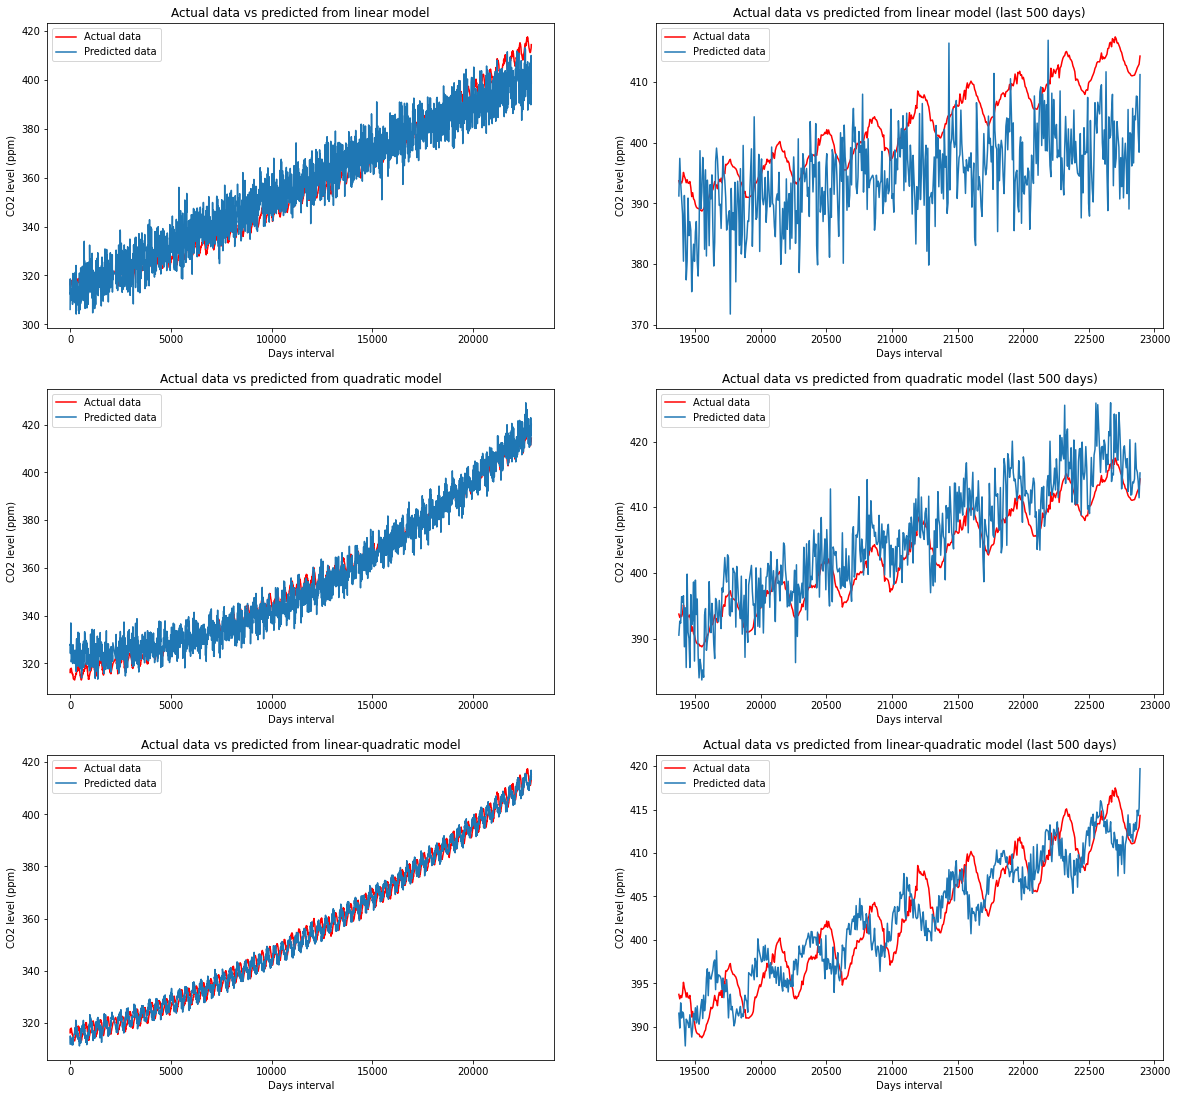

In [55]:
# Plot the prediction from the model
# sns.set_style("whitegrid")
fig = plt.figure(figsize=(20,5))
plt.subplots_adjust(bottom=-2)

plt.subplot(3,2,1)
plt.plot(number_of_days, co2_level,c='red', label='Actual data')
plt.plot(number_of_days, linear_model(posterior_samples_linear, number_of_days, np.mean), label='Predicted data')
plt.title("Actual data vs predicted from linear model")
plt.xlabel("Days interval")
plt.ylabel("CO2 level (ppm)")
plt.legend()

plt.subplot(3,2,2)
plt.plot(number_of_days[-500:], co2_level[-500:], c='red', label='Actual data')
plt.plot(number_of_days[-500:], linear_model(posterior_samples_linear, number_of_days[-500:], np.mean), label='Predicted data')
plt.title("Actual data vs predicted from linear model (last 500 days)")
plt.xlabel("Days interval")
plt.ylabel("CO2 level (ppm)")
plt.legend()

plt.subplot(3,2,3)
plt.plot(number_of_days, co2_level, c='red', label='Actual data')
plt.plot(number_of_days, quadratic_model(posterior_samples_quadratic, number_of_days, np.mean), label='Predicted data')
plt.title("Actual data vs predicted from quadratic model")
plt.xlabel("Days interval")
plt.ylabel("CO2 level (ppm)")
plt.legend()

plt.subplot(3,2,4)
plt.plot(number_of_days[-500:], co2_level[-500:], c='red', label='Actual data')
plt.plot(number_of_days[-500:], quadratic_model(posterior_samples_quadratic, number_of_days[-500:], np.mean), label="Predicted data")
plt.title("Actual data vs predicted from quadratic model (last 500 days)")
plt.xlabel("Days interval")
plt.ylabel("CO2 level (ppm)")
plt.legend()

plt.subplot(3,2,5)
plt.plot(number_of_days, co2_level, c='red', label='Actual data')
plt.plot(number_of_days, linear_quadratic_model(posterior_samples_linear_quad, number_of_days, np.mean), label='Predicted data')
plt.title("Actual data vs predicted from linear-quadratic model")
plt.xlabel("Days interval")
plt.ylabel("CO2 level (ppm)")
plt.legend()

plt.subplot(3,2,6)
plt.plot(number_of_days[-500:], co2_level[-500:], c='red', label='Actual data')
plt.plot(number_of_days[-500:], linear_quadratic_model(posterior_samples_linear_quad, number_of_days[-500:], np.mean), label='Predicted data')
plt.title("Actual data vs predicted from linear-quadratic model (last 500 days)")
plt.xlabel("Days interval")
plt.ylabel("CO2 level (ppm)")
plt.legend()

## 95% CONFIDENCE INTERVAL FOR ATMOSPHERIC CO2 LEVELS PROJECTED UNTIL THE START OF 2060


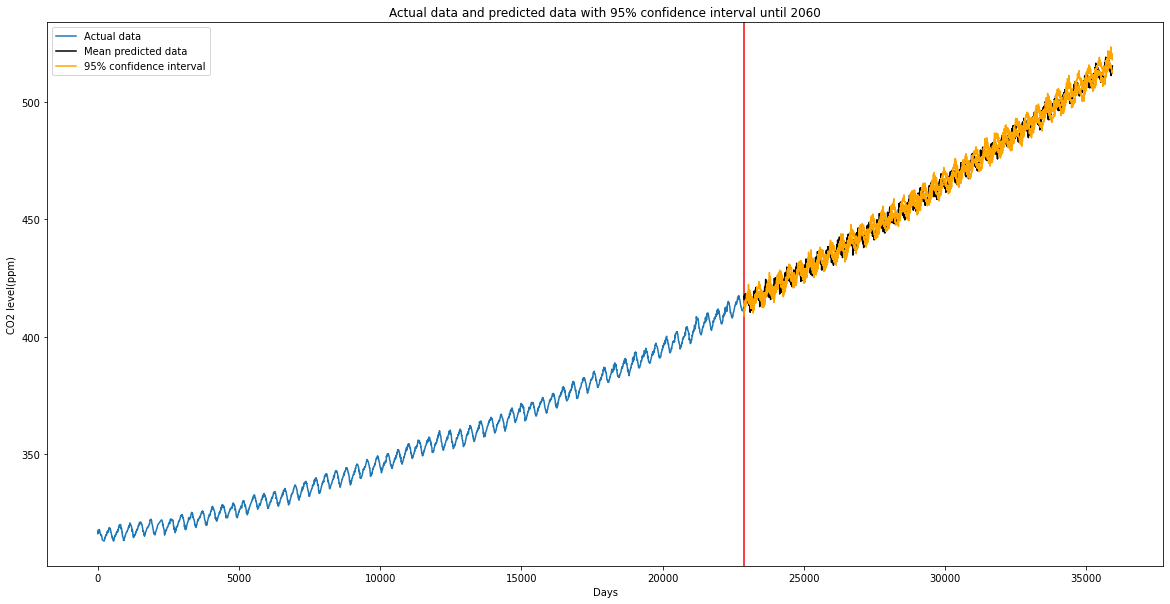

In [56]:
##### PLOT THE 95% CONFIDENCE INTERVAL OF CO2 LEVELS #####
fig = plt.figure(figsize=(20,10))
time_range = np.arange(0,35936,7) # 40 years from now 

# Prepare data to plot 
mean_predicted_data = linear_quadratic_model(posterior_samples_linear_quad, time_range, np.mean)
lower_bound_predicted_data = linear_quadratic_model(posterior_samples_linear_quad, time_range, np.percentile, 2.5)
upper_bound_predicted_data = linear_quadratic_model(posterior_samples_linear_quad, time_range, np.percentile, 97.5)

# Plot the data
plt.axvline(number_of_days[3198],color='red') # Current time

plt.plot(number_of_days, co2_level, label='Actual data')
plt.plot(time_range[number_of_days.shape[0]+70:],mean_predicted_data[number_of_days.shape[0]+70:], color="black", label='Mean predicted data')
plt.plot(time_range[number_of_days.shape[0]+70:],lower_bound_predicted_data[number_of_days.shape[0]+70:],color="orange",label='95% confidence interval')
plt.plot(time_range[number_of_days.shape[0]+70:],upper_bound_predicted_data[number_of_days.shape[0]+70:],color="orange")

plt.title("Actual data and predicted data with 95% confidence interval until 2060")
plt.xlabel("Days")
plt.ylabel("CO2 level(ppm)")
plt.legend()
plt.show()

In [57]:
len(number_of_days)

3199

In [58]:
number_of_days

0           0
1           7
2          14
3          21
4          28
        ...  
3194    22862
3195    22869
3196    22876
3197    22883
3198    22890
Name: Days interval, Length: 3199, dtype: int64

In [59]:
number_of_days[3198]

22890

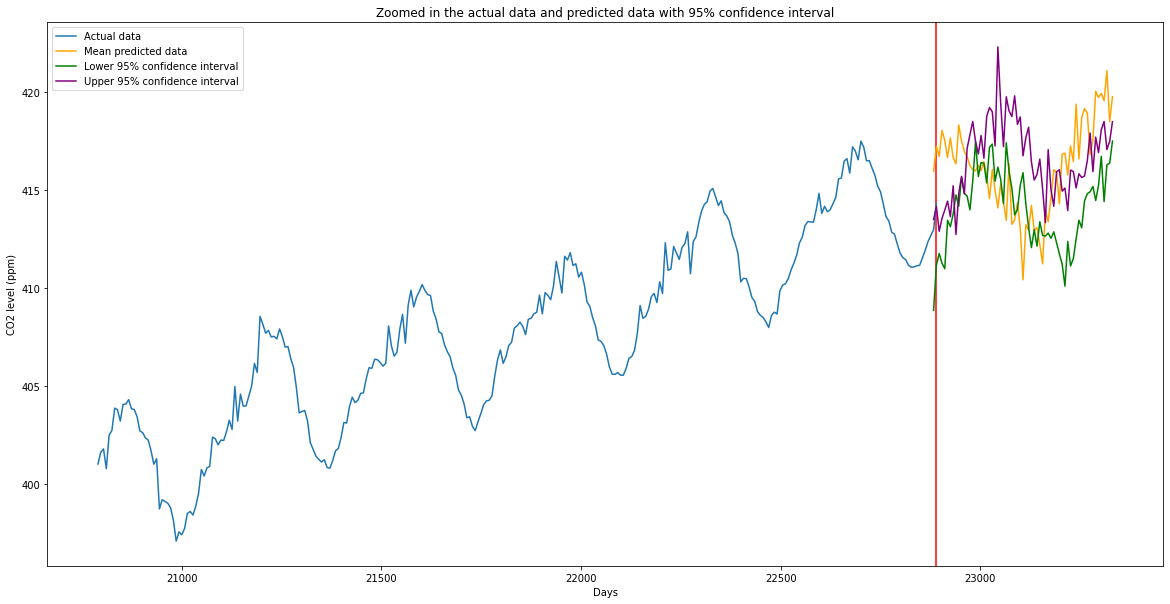

In [60]:
##### ZOOMED IN THE 95% CONFIDENCE INTERVAL OF CO2 LEVELS #####
fig = plt.figure(figsize=(20,10))

plt.axvline(number_of_days[3198],color='red') # Current time

plt.plot(number_of_days[-300:], co2_level[-300:], label='Actual data')
plt.plot(time_range[number_of_days.shape[0]+70:-1800], mean_predicted_data[number_of_days.shape[0]+70:-1800], color="orange", label='Mean predicted data')
plt.plot(time_range[number_of_days.shape[0]+70:-1800], lower_bound_predicted_data[number_of_days.shape[0]+70:-1800], color="green",label='Lower 95% confidence interval')
plt.plot(time_range[number_of_days.shape[0]+70:-1800], upper_bound_predicted_data[number_of_days.shape[0]+70:-1800], color="purple", label='Upper 95% confidence interval')

plt.title("Zoomed in the actual data and predicted data with 95% confidence interval")
plt.xlabel("Days")
plt.ylabel("CO2 level (ppm)")
plt.legend()
plt.show()

## ESTIMATION OF WHEN CO2 LEVELS REACH 450 PPM


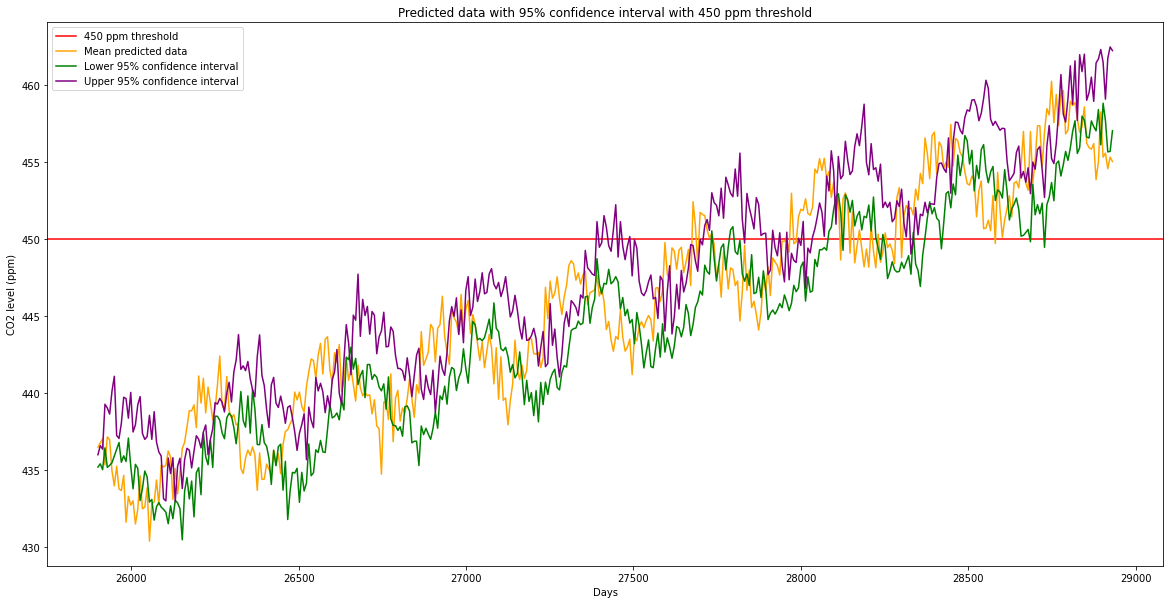

In [61]:
# ##### PLOT THE ESTIMATION ######
fig = plt.figure(figsize=(20,10))
plt.axhline(450, color='red', label='450 ppm threshold') # Plot the threshold

plt.plot(time_range[3700:-1000], mean_predicted_data[3700:-1000], color="orange", label='Mean predicted data')
plt.plot(time_range[3700:-1000], lower_bound_predicted_data[3700:-1000],color="green", label='Lower 95% confidence interval')
plt.plot(time_range[3700:-1000:], upper_bound_predicted_data[3700:-1000],color="purple", label='Upper 95% confidence interval')

plt.title("Predicted data with 95% confidence interval with 450 ppm threshold")
plt.xlabel("Days")
plt.ylabel("CO2 level (ppm)")
plt.legend()
plt.show()

In [62]:
##### CALCULATE THE LOWER BOUND AND UPPER BOUND OF CO2 LEVEL #####
df = pd.DataFrame(data={"day": time_range, "Mean CO2": mean_predicted_data, "Lower CO2": lower_bound_predicted_data, \
                        "Upper CO2": upper_bound_predicted_data})
df.head(10)

,day,Mean CO2,Lower CO2,Upper CO2
0,0,313.674594,317.133822,319.119442
1,7,314.651005,317.739760,318.074081
2,14,314.846896,316.994457,318.310323
3,21,313.239817,316.636489,316.035170
4,28,314.259757,317.205542,319.137373
5,35,313.571752,316.365069,316.410437
6,42,312.401546,318.073245,318.849580
7,49,312.845060,317.414303,317.033387
8,56,311.487170,316.582490,319.160912
9,63,312.992404,316.147534,317.595906


In [63]:
##### TRANSLATE FROM DAYS OF INTERVAL TO DATE FORMAT MM-DD-YYYY ######

mean_day_450 = list(df[df['Mean CO2']>=450].day)[0]
lower_day_450 = list(df[df['Lower CO2']>=450].day)[0]
upper_day_450 = list(df[df['Upper CO2']>=450].day)[0]

# 1958-03-29 as day 0
day_0 = datetime(year=1958, month=3, day=29)
mean = day_0 + timedelta(days=mean_day_450)
lower = day_0 + timedelta(days=lower_day_450)
upper = day_0 + timedelta(days=upper_day_450)

print(f'On average the CO2 level reaches 450 ppm on date: {mean.month}-{mean.day}-{mean.year}')
print(f'The lower 95% confidence interval of the date CO2 level reaches 450 ppm is: {lower.month}-{lower.day}-{lower.year}')
print(f'The upper 95% confidence interval of the date CO2 level reaches 450 ppm is: {upper.month}-{upper.day}-{upper.year}')


On average the CO2 level reaches 450 ppm on date: 1-7-2034
The lower 95% confidence interval of the date CO2 level reaches 450 ppm is: 3-4-2034
The upper 95% confidence interval of the date CO2 level reaches 450 ppm is: 3-26-2033
